In [35]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append('..')
from packages import utils
import importlib
importlib.reload(utils)

<module 'packages.utils' from '/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/gourmand_data_analysis/../packages/utils.py'>

In [12]:
cg_df = pd.read_parquet('cg_est', engine='pyarrow')
bh_df: pd.DataFrame = pd.read_parquet('bus_holdings.snappy.parquet', engine='pyarrow')
bus_cats_df = pd.read_parquet('bus_cats', engine='pyarrow')
bt_df = pd.read_parquet('business_transactions.snappy.parquet', engine='pyarrow')

To go a bit further with our previous analysis we will just use a function to get the most recent businesses while also removing those with null values.
> Note: Nulls are being removed since in the previous analysis there were less than 10 observations with such characteristics

In [40]:
most_recent_bh_tran_df = utils.most_recent_businesses_df(df1 = bh_df, df2= bt_df, on= 'BusinessKey', remove_na=True)
most_recent_bh_tran_df

,BusinessKey,BusinessName_x,ChainName,BusinessRating,ReviewCount,previous_review_cnt,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,total_bus_rating_delta,CloseDate,BusinessName_y,transactioncounts,transactions_list
0,53160,deutschlander-buffalo-gap-2,Deutschlander,4.0,37,37.0,4.000000000,0.0,0E-9,0.0,0E-9,2022-01-14,deutschlander-buffalo-gap-2,0,other
1,9203,sips-and-such-café-alma,Sips and Such Café,5.0,4,4.0,5.000000000,0.0,0E-9,0.0,0E-9,2022-01-14,sips-and-such-café-alma,0,other
2,27671,la-fuente-mexican-restaurant-meridian,La Fuente Mexican Restaurant,4.0,41,41.0,4.000000000,0.0,0E-9,0.0,0E-9,2022-01-28,la-fuente-mexican-restaurant-meridian,1,delivery
3,48461,red-oak-roasters-rickman-3,Red Oak Roasters,5.0,6,6.0,5.000000000,0.0,0E-9,1.0,0E-9,2022-02-06,red-oak-roasters-rickman-3,0,other
4,28381,arcadia-valley-roasting-company-ironton,Arcadia Valley Roasting Company,4.5,7,7.0,4.500000000,0.0,0E-9,0.0,0E-9,2022-02-07,arcadia-valley-roasting-company-ironton,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63308,23543,zzs-sports-bar-and-grill-adrian,ZZ's Sports Bar & Grill,3.5,10,10.0,3.500000000,0.0,0E-9,-60.0,0E-9,2022-02-27,zzs-sports-bar-and-grill-adrian,0,other
63309,5467,zzzz-s-pizzzza-burlington,ZZZZ’s PIzzzza,5.0,1,1.0,5.000000000,0.0,0E-9,-1.0,0.500000000,2022-02-27,zzzz-s-pizzzza-burlington,0,other
63310,13045,àlavita-boise-2,ÀLAVITA,4.0,308,309.0,4.000000000,-1.0,0E-9,55.0,-0.500000000,2022-02-27,àlavita-boise-2,1,delivery
63311,44974,ándale-caguas-2,Ándale,5.0,3,3.0,5.000000000,0.0,0E-9,0.0,0E-9,2022-02-27,ándale-caguas-2,0,other


In the last analysis we decided to a higher-order polynomial of `BusinessRating` due to the following informative visualization.

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Text(0.5, 1.0, 'higher-order polynomial of explanatory variable')

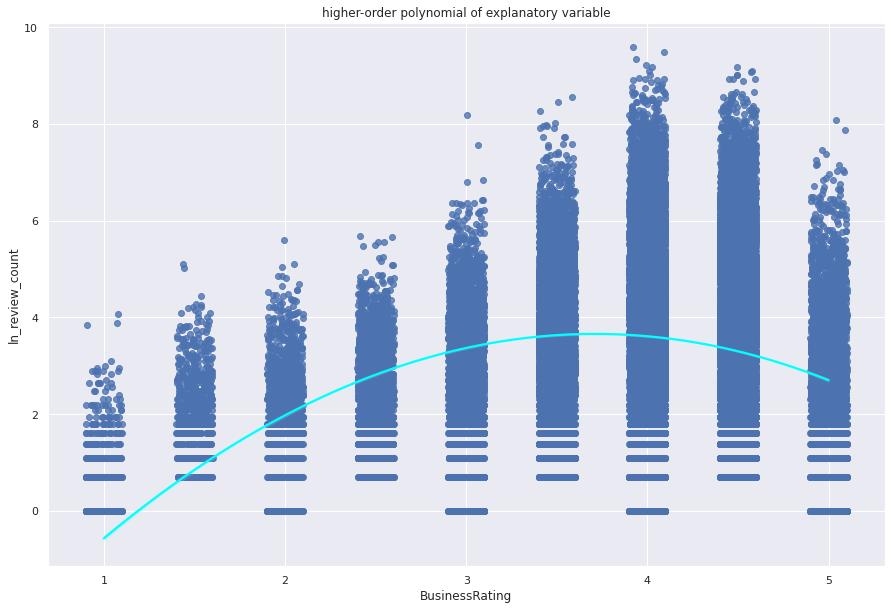

In [44]:
most_recent_bh_tran_sin_cero_df = most_recent_bh_tran_df[most_recent_bh_tran_df['ReviewCount'] > 0 ]
most_recent_bh_tran_sin_cero_df.loc[:, 'ln_review_count'] = np.log(most_recent_bh_tran_sin_cero_df['ReviewCount'])
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.regplot(
    x=most_recent_bh_tran_sin_cero_df['BusinessRating'],
    y=most_recent_bh_tran_sin_cero_df['ln_review_count'], x_jitter=.10, order=2,
    line_kws={'color':'cyan'})

plt.title('higher-order polynomial of explanatory variable')

We also estimated the fit of the regression with OLS and got better results after having taken the square compared to not having taken it and also the natural log of `ReviewCount`.

In [79]:
most_recent_bh_tran_sin_cero_df.loc[:, 'BusinessRating_squared'] = most_recent_bh_tran_sin_cero_df.loc[:, 'BusinessRating'] ** 2
X_br_brsquared = most_recent_bh_tran_sin_cero_df.loc[:, ['BusinessRating_squared', 'BusinessRating']]
X_br_brsquared_with_constant = sm.add_constant(X_br_brsquared)
y = most_recent_bh_tran_sin_cero_df['ln_review_count']
univariate_lin_model_rc_br = sm.OLS(y, X_br_brsquared_with_constant)
univariate_lin_model_rc_br_results = univariate_lin_model_rc_br.fit(cov_type='HC1')
univariate_lin_model_rc_br_results.summary()

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_review_count   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     6495.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:57:24   Log-Likelihood:            -1.2278e+05
No. Observations:               63307   AIC:                         2.456e+05
Df Residuals:                   63304   BIC:                         2.456e+05
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.2646      0.067    -63.979      0.000      -4.395      -4.134
BusinessRating_squared    -0.5754      0.006    -93.466      0.000      -0.587      -0.563
BusinessRating             4.2702      0.041    103.253      0.000       4.189       4.351
==============================================================================
Omnibus:                      941.995   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              595.992
Skew:                           0.091   Prob(JB):                    3.82e-130
Kurtosis:                       2.561   Cond. No.                         240.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

One effective method of helping to assure that this is a good path to take, is to visualize the regressions with their confidence intervals.

Text(0.5, 1.0, "CI's of various plots")

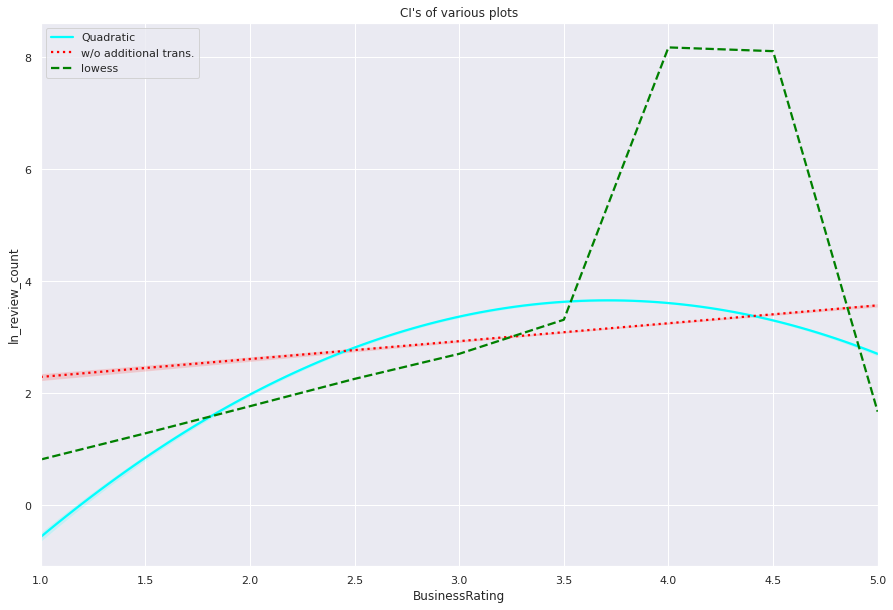

In [63]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.regplot(
    x=most_recent_bh_tran_sin_cero_df['BusinessRating'],
    y=most_recent_bh_tran_sin_cero_df['ln_review_count'], order=2,scatter=False, ci=99, n_boot=1000,
    line_kws={'color':'cyan'}, label= "Quadratic", ax=ax)

sns.regplot(
    x=most_recent_bh_tran_sin_cero_df['BusinessRating'],
    y=most_recent_bh_tran_sin_cero_df['ln_review_count'], scatter=False, ci=99, n_boot=1000,
    line_kws={'color':'red', 'linestyle': ':'}, label="w/o additional trans.",  ax=ax)

sns.regplot(
    x=most_recent_bh_tran_sin_cero_df['BusinessRating'],
    y=most_recent_bh_tran_sin_cero_df['ln_review_count'], scatter=False,
    line_kws={'color':'green', 'linestyle': '--'}, lowess=True, label="lowess",  ax=ax)
plt.legend()
plt.title('CI\'s of various plots')

It turns out here that the confidence intervals are rather small so there's no indication of much overlap specifically between the normal linear regression and the quadratic. However we can be observe that the quadratic does a much better job of approximating the lowess regression so that itself is a good sign that the quadratic is more effective.

In [64]:
from stargazer.stargazer import Stargazer

ModuleNotFoundError: No module named 'stargazer'

We may arrive at the question of "Is there even a difference in the population between the two slope coefficients in our equation?". There are two approaches to answering this question : Reviewing the confidence intervals and the doing a more formal hypothesis test with bootstrap.

In [68]:
univariate_lin_model_rc_br_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:               OLS               Adj. R-squared:      0.127      
Dependent Variable:  ln_review_count   AIC:                 245560.2042
Date:                2022-03-03 13:23  BIC:                 245587.3715
No. Observations:    63307             Log-Likelihood:      -1.2278e+05
Df Model:            2                 F-statistic:         6495.      
Df Residuals:        63304             Prob (F-statistic):  0.00       
R-squared:           0.127             Scale:               2.8319     
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                  -4.2646   0.0667 -63.9793 0.0000 -4.3953 -4.1340
BusinessRating_squared -0.5754   0.0062 -93.4659 0.0000 -0.5874 -0.5633
BusinessRating          4.2702   0.0414 103.2531 0.0000  4.1891  4.3512
-----------------------------------------------------------------------
Omnibus:                941.995        Durbin-Watson:           1.693  
Prob(Omnibus):          0.000          Jarque-Bera (JB):        595.992
Skew:                   0.091          Prob(JB):                0.000  
Kurtosis:               2.561          Condition No.:           240    
=======================================================================

"""

Looking at the CI's we absolutely no overlap nor do we see one coefficient's point estimate in another's CI.

In [69]:
univariate_lin_model_rc_br_results.conf_int()

,0,1
const,-4.395266,-4.133978
BusinessRating_squared,-0.587435,-0.563304
BusinessRating,4.189102,4.351216


In [74]:
univariate_lin_model_rc_br_results.params

const                    -4.264622
BusinessRating_squared   -0.575370
BusinessRating            4.270159
dtype: float64

Using the bootstrap method we could arrive at the same conclusion in a more formal manner.

In [76]:
import random

In [88]:
random.seed(42)
coeff_results = []
for i in range(500):

    ixs = random.choices(population = most_recent_bh_tran_sin_cero_df.index.tolist() ,k=most_recent_bh_tran_sin_cero_df.shape[0])
    sample_df = most_recent_bh_tran_sin_cero_df.loc[ixs,:]

    X_br_brsquared_sample = sample_df.loc[:, ['BusinessRating_squared', 'BusinessRating']]
    X_br_brsquared_sample_with_constant = sm.add_constant(X_br_brsquared_sample)

    y_sample = sample_df['ln_review_count']
    univariate_lin_model_rc_br_sample = sm.OLS(y_sample, X_br_brsquared_sample_with_constant)
    univariate_lin_model_rc_br_sample_results = univariate_lin_model_rc_br_sample.fit(cov_type='HC1')

    br2 = univariate_lin_model_rc_br_sample_results.params[1]
    br = univariate_lin_model_rc_br_sample_results.params[-1]
    coeff_result = br - br2
    coeff_results.append(coeff_result)

Calculating the statistic from our dataset shows of course a difference

In [89]:
the_stat = univariate_lin_model_rc_br_results.params[-1] - univariate_lin_model_rc_br_results.params[1]

the_stat

4.845528588478763

Now with the accompanying t-statistic and the confidence interval we can be confident that there is a difference
> Note: Having done a quick test of the bootstrap script with 10000 samples of 10 observations the se was approximately 17.

In [90]:
coeff_results_se = np.std(coeff_results)
coeff_results_se

0.04760003747038293

In [91]:
the_stat / coeff_results_se

101.79673895201626

In [93]:
print(f'Difference of two slope coeffcients CI with 95% confidence {the_stat - (coeff_results_se * 2):.5f} <---> {the_stat + (coeff_results_se * 2):.5f} ', end=' ')

Difference of two slope coeffcients CI with 95% confidence 4.75033 <---> 4.94073  

Now having went through the process of statistical inference we have to now consider the question of external validity.\
The question to be whether to confirm if our discoveries would hold across different states (or even countries), across time, and also different businesses. We'll focus on space and subgroups for the moment.

> come back and continue the ev analysis and also try Stargazer